# Introduction

In this project, I have built a neural network of my own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


**Important: Restart the Kernel at this moment**

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run script troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [4]:
!python --version

Python 3.12.4


## Load the Dataset

Specify transforms as a list.
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, we can create our dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once the dataset is created, we also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(), 
])


# Create training set 
trainset = datasets.MNIST(root = "./data", train = True, download = True, transform = transform)
# Create test set
testset = datasets.MNIST(root = "./data", train = False, download = True, transform = transform)
# Create valid data set
from torch.utils.data import random_split

train_size = int(0.8 * len(trainset))  
val_size = len(trainset) - train_size  

trainset, validset = random_split(trainset, [train_size, val_size])
# Create Data loader
trainloader = DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = DataLoader(testset, batch_size = 64, shuffle = True)
validloader = DataLoader(validset, batch_size = 64, shuffle = True)

**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

We can view images using the `show5` function defined below – it takes a data loader as an argument.
Normalized images will look really weird! 
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training the network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


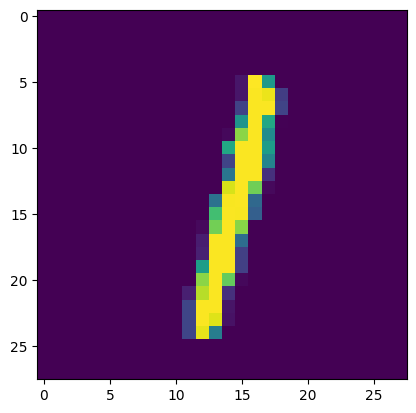

4


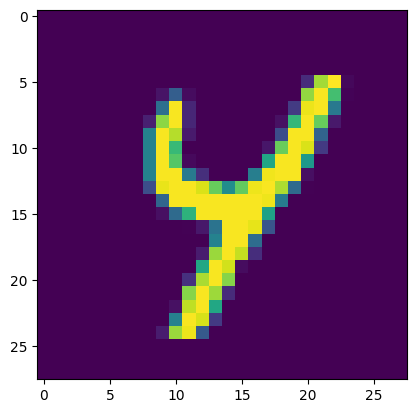

7


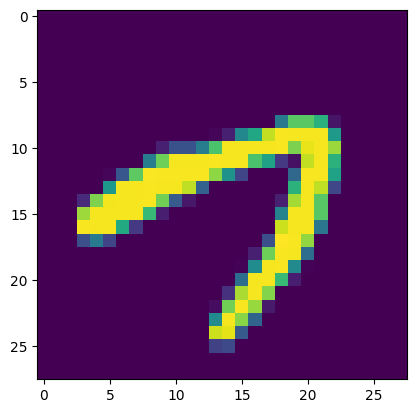

9


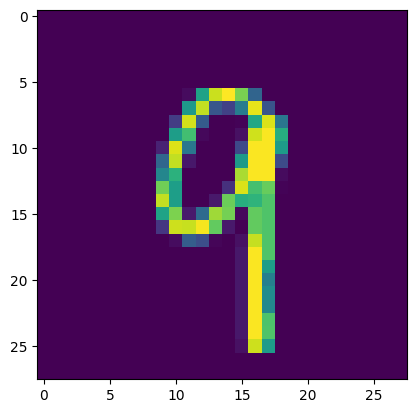

4


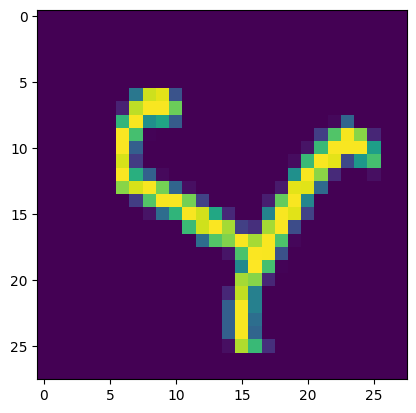

In [7]:
# Explore data
## YOUR CODE HERE ##
show5(trainloader)

## Build your Neural Network

## Network Structure

*Input images shape [batch_size = 64, 1, 28, 28]*

**Convolutional layer 1**
1. Applies 32 filters of size 3x3
2. Keeps spatial size same due to
3. Output shape: [batch_size = 64, 32, 28, 28]

**Convolutional layer 2**
1. Applies 64 filters of size 3x3
2. Output Shape: [batch_size = 64, 64, 28, 28]

**Max Pooling Layer**
1. Reduces height and width by half (2×2)
2. After both conv+pool blocks, image shape: [batch_size = 64, 64, 7, 7]

**Flatten and Fully Connected layers(fc1 and fc2)**
1. Flattens the 64×7×7 feature map to a 1D vector of 3136 values
2. Fully connected layer transforms the features into a 128-dimensional vector(fc1)
3. Output of 10 values — one per digit class (0–9)(fc2).

**Dropout Layer**
1. Randomly drops 25% of neurons during training to prevent overfitting

Relu activation function is used in the hidden layer.

In [8]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*7*7, 128)           
        self.fc2 = nn.Linear(128, 10)           
        
        self.dropout = nn.Dropout(0.25)                   #Randomly drops 25% of neurons.

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                       
        x = self.pool(F.relu(self.conv2(x)))                  
        x = x.view(-1, 64*7*7)                   
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

In [9]:
## Loss Function
def cross_entropy_loss(probs, targets):
    """Mean cross‑entropy loss.
    `probs` shape (N,10) after softmax
    `targets` is long tensor of labels (N,)"""
    N = probs.shape[0]
    log_prob = np.log(probs)
    log_prob_target = log_prob[np.arange(N), targets]
    return -np.sum(log_prob_target)/ N

model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

inputs = torch.randn(64, 1, 28, 28)
labels = torch.randint(0, 10, (32,))


## Running Neural Network
Train the neural network, and record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
# Check shapes in trainloader
for images, labels in trainloader:
    print(f"Train batch shape: {images.shape}")  
    break
# Check shapes in testloader
for images, labels in testloader:
    print(f"Train batch shape: {images.shape}")  
    break

Train batch shape: torch.Size([64, 1, 28, 28])
Train batch shape: torch.Size([64, 1, 28, 28])


In [11]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! 🟢")
    device = torch.device("cuda")
else:
    print("CUDA is NOT available. Using CPU. 🔴")
    device = torch.device("cpu")

CUDA is NOT available. Using CPU. 🔴


In [12]:
## Running the network
model = MyCNN().to(device)
# Initialize list to store average training loss per epoch
train_losses = []
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0
    
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        #---------------Forward Pass--------------#
        output = model(images)
        loss = criterion(output, labels)

        #---------------Backward Pass--------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

    # Validation after each epoch

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)

            val_output = model(images)
            _, predicted = torch.max(val_output, 1)  # Get index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

accuracy = correct * 100 / total
print(f'Validation Accuracy: {accuracy:.2f}%')

Epoch 1, Loss: 2.3070
Epoch 2, Loss: 2.3068
Epoch 3, Loss: 2.3068
Epoch 4, Loss: 2.3068
Epoch 5, Loss: 2.3071
Validation Accuracy: 7.88%


Plot the training loss (and validation loss/accuracy, if recorded).

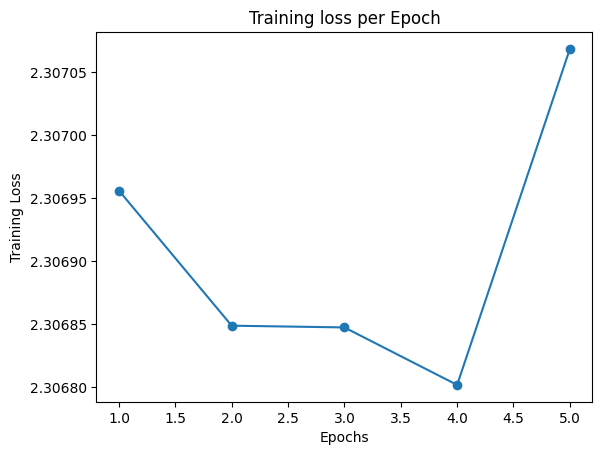

In [13]:
plt.plot(range(1, epochs+1), train_losses, marker = "o")
plt.title("Training loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
model = model.to(device)
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)  # Get index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct * 100 / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 7.42%


## Improving your model
to improve accuracy on the test set!

**Hyperparameter tuning - Changed the optimizer**

In [15]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 


for epoch in range(epochs):
    running_loss = 0.0
    
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        #---------------Forward Pass--------------#
        output = model(images)
        loss = criterion(output, labels)

        #---------------Backward Pass--------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

    # Validation after each epoch

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)

            val_output = model(images)
            _, predicted = torch.max(val_output, 1)  # Get index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

accuracy = correct * 100 / total
print(f'Validation Accuracy: {accuracy:.2f}%')


# Testing Model with Test set
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)  # Get index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct * 100 / total
print(f'Test Accuracy: {accuracy:.2f}%')

Epoch 1, Loss: 0.2401
Epoch 2, Loss: 0.0743
Epoch 3, Loss: 0.0535
Epoch 4, Loss: 0.0431
Epoch 5, Loss: 0.0349
Validation Accuracy: 98.84%
Test Accuracy: 98.91%


# Testing with a MNIST dataset photo (Optional)

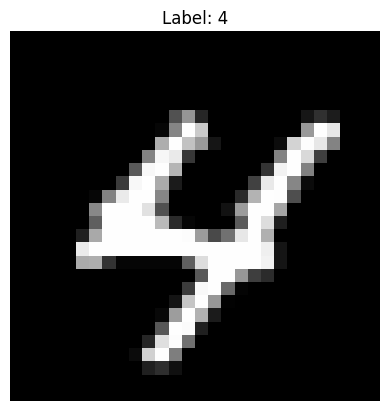

Predicted Digit: 4


In [18]:
import matplotlib.pyplot as plt
# Get one batch from the testloader
dataiter = iter(testloader)
images, labels = next(dataiter)
# Select one image and its label
img = images[0]
label = labels[0]
# Show the image
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Label: {label.item()}")
plt.axis('off')
plt.show()

# Set model to evaluation mode
model.eval()

# Move image to the same device as model
img = img.to(device)

# Add batch dimension: [1, 1, 28, 28]
img = img.unsqueeze(0)

# Disable gradient computation
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)

print(f"Predicted Digit: {predicted.item()}")

## Saving your model
Using `torch.save`, save your model for future loading.

In [17]:
torch.save(model.state_dict(), 'model.pth')